In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [7]:

zphi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm)

In [105]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_merged = uvel_merged.isel(time=slice(1,100)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(1,100)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [106]:
def lanczos(x, a):
    return np.sinc(x/a)

In [107]:
window_width=30
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [189]:
u_eul_filtered = uvel_merged.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
v_eul_filtered = vvel_merged.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_eul_filtered = u_eul_filtered.sel(time=slice(42,42+33)).assign_coords({'time':np.arange(0,33)*3600})
v_eul_filtered = v_eul_filtered.sel(time=slice(42,42+33)).assign_coords({'time':np.arange(0,33)*3600})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xarray/core/computation.py:1215: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [10]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,33):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=30
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=3)
        v_piece = windowed_v.sel(time=0).isel(z0=3)
        u_piece2 = ds.u.sel(time=0).isel(z0=3)
        v_piece2 = ds.v.sel(time=0).isel(z0=3)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [11]:
#spectrum unfiltered lagrang
with ProgressBar():
    uhat_un = xrft.power_spectrum(u_unfiltered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
    vhat_un = xrft.power_spectrum(v_unfiltered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
ekehat_un = .5*(uhat_un + vhat_un)

[########################################] | 100% Completed | 35.0s
[########################################] | 100% Completed | 55.3s


In [12]:
#spectrum_filtered_lagrang
with ProgressBar():
    uhat2 = xrft.power_spectrum(u_filtered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
    vhat2 = xrft.power_spectrum(v_filtered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
ekehat = .5*(uhat2 + vhat2)

[########################################] | 100% Completed |  1min 27.8s
[########################################] | 100% Completed |  1min 56.0s


In [141]:
#spectrum_filtered_eul
with ProgressBar():
    uhat2eul = xrft.power_spectrum(u_eul_filtered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
    vhat2eul = xrft.power_spectrum(v_eul_filtered.chunk({'time':-1}),dim='time', window=True).compute()#, detrend='linear'
ekehat_eul = .5*(uhat2eul + vhat2eul)

[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  5.0s


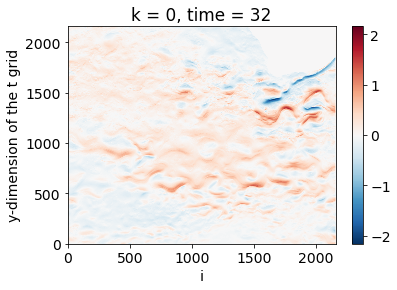

In [128]:
(u_eul_filtered).isel(time=-1).plot(x='i')

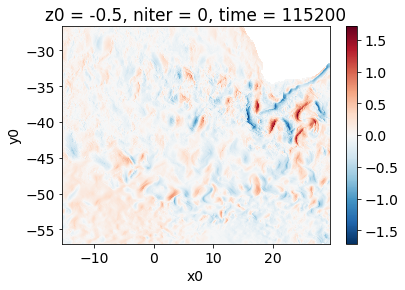

In [129]:
(v_filtered).isel(time=-1).plot(x='x0')

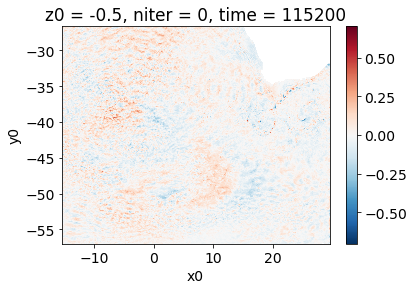

In [15]:
(v_unfiltered-v_filtered).isel(time=-1).plot(x='x0')

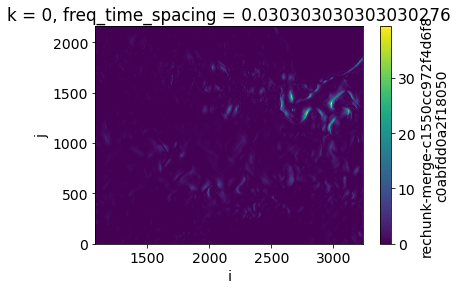

In [130]:
vhat2eul.sum('freq_time').plot()

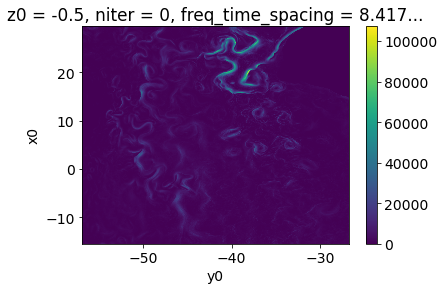

In [17]:
ekehat_un.sum('freq_time').plot()

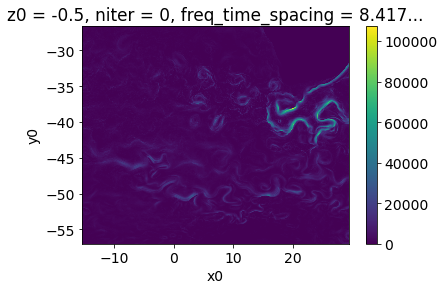

In [18]:
ekehat_un.sum('freq_time').plot(x='x0')

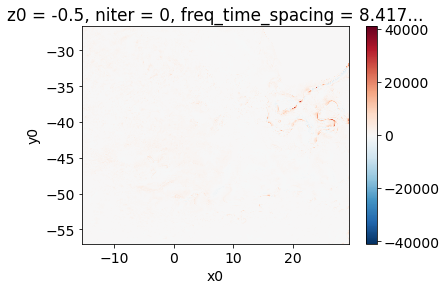

In [19]:
(ekehat_un.sum('freq_time') - ekehat.sum('freq_time')).plot(x='x0')

In [142]:
spec0 = int((ekehat['freq_time'].size-1)/2)

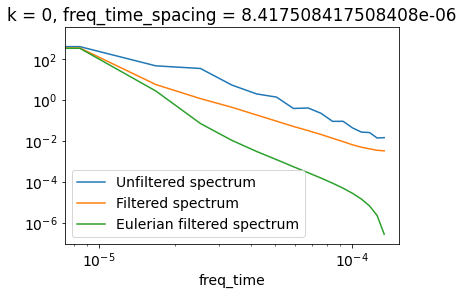

In [143]:
(ekehat_un).mean(['x0','y0'])[spec0:].plot(label='Unfiltered spectrum')
(ekehat).mean(['x0','y0'])[spec0:].plot(label='Filtered spectrum')
(ekehat_eul).mean(['i','j'])[spec0:].plot(label='Eulerian filtered spectrum')
plt.legend()
plt.xscale('log')
plt.yscale('log')

In [190]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", ekehat.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", ekehat.y0.values)).swap_dims({"j": "y0"})

In [191]:
lons, lats = np.meshgrid(u_filtered.x0.values, u_filtered.y0.values)

In [192]:
def target_area_def(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat = center_point.x0.values.item(), -center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lat_0': center_lat, 'lon_0': center_lon, 'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 1, 0))

def ufunc_resample(data):
    target_def = target_area_def(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lons, lats=-lats)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['x0','y0'],['x0','y0']],output_core_dims=[['y1','x1']])
    return resampled

In [195]:
u_eul_resampled = ufunc_resample(u_eul_filtered.load())
v_eul_resampled = ufunc_resample(v_eul_filtered.load())
u_resampled = ufunc_resample(u_filtered.load())
v_resampled = ufunc_resample(v_filtered.load())
u_resampled_unfilt = ufunc_resample(u_unfiltered.load())
v_resampled_unfilt = ufunc_resample(v_unfiltered.load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [196]:
u_eul_resampled = u_eul_resampled.assign_coords(x1=("x1", u_eul_resampled.x1.values)).assign_coords(y1=("y1", u_eul_resampled.y1.values))
v_eul_resampled = v_eul_resampled.assign_coords(x1=("x1", v_eul_resampled.x1.values)).assign_coords(y1=("y1", v_eul_resampled.y1.values))
u_resampled = u_resampled.assign_coords(x1=("x1", u_resampled.x1.values)).assign_coords(y1=("y1", u_resampled.y1.values))
v_resampled = v_resampled.assign_coords(x1=("x1", v_resampled.x1.values)).assign_coords(y1=("y1", v_resampled.y1.values))
u_resampled_unfilt = u_resampled_unfilt.assign_coords(x1=("x1", u_resampled_unfilt.x1.values)).assign_coords(y1=("y1", u_resampled_unfilt.y1.values))
v_resampled_unfilt = v_resampled_unfilt.assign_coords(x1=("x1", v_resampled_unfilt.x1.values)).assign_coords(y1=("y1", v_resampled_unfilt.y1.values))

In [197]:
with ProgressBar():
    u2_ps = xrft.power_spectrum(u_resampled, dim=['x1','y1','time'],window=True).compute()
    v2_ps = xrft.power_spectrum(v_resampled, dim=['x1','y1','time'],window=True).compute()
vel_ps = (u2_ps + v2_ps)*0.5

In [198]:
with ProgressBar():
    u2_ps_unfilt = xrft.power_spectrum(u_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
    v2_ps_unfilt = xrft.power_spectrum(v_resampled_unfilt, dim=['x1','y1','time'],window=True).compute()
vel_ps_unfilt = (u2_ps_unfilt + v2_ps_unfilt)*0.5

In [199]:
with ProgressBar():
    u2_ps_eul = xrft.power_spectrum(u_eul_resampled, dim=['x1','y1','time'],window=True).compute()
    v2_ps_eul = xrft.power_spectrum(v_eul_resampled, dim=['x1','y1','time'],window=True).compute()
vel_ps_eul = (u2_ps_eul + v2_ps_eul)*0.5

In [200]:
u2_wavenumber = xrft.isotropic_power_spectrum(u_resampled, dim=['x1','y1'],window=True)
v2_wavenumber = xrft.isotropic_power_spectrum(v_resampled, dim=['x1','y1'],window=True)

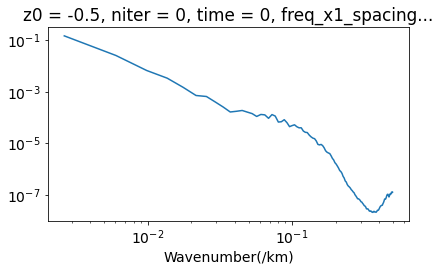

In [201]:
vel_wavenumber = (u2_wavenumber+v2_wavenumber)*0.5
vel_wavenumber.isel(time=0).plot()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavenumber(/km)')
plt.tight_layout()

fig=plt.gcf()
fig.savefig('wavenumber.png')

In [202]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [203]:
ps_iso = iso_spec(vel_ps)
ps_iso_unfilt = iso_spec(vel_ps_unfilt)
ps_iso_eul = iso_spec(vel_ps_eul)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [204]:
RdS

array([6.41302021e+09, 1.11708743e+04, 6.12413700e+03, 3.96194900e+03,
       2.78315702e+03, 2.14365771e+03])

In [205]:
kr    = ps_iso.kr
omegaM = np.nan*np.ones([kr.shape[0], 6])
for i in range(1,6):
    
    Kdi = 1/RdS[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*2*np.pi)**2/Kdi**2).values)**0.5*3600

Text(0, 0.5, '$\\omega$')

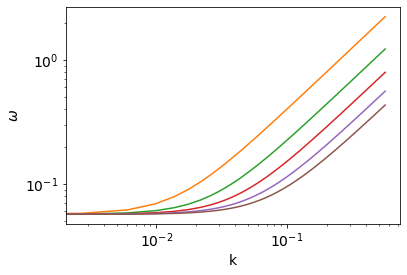

In [206]:
plt.plot(kr, omegaM/2/np.pi)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('$\omega$')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:39: UserWarning: Log scale: values of z <= 0 have been masked


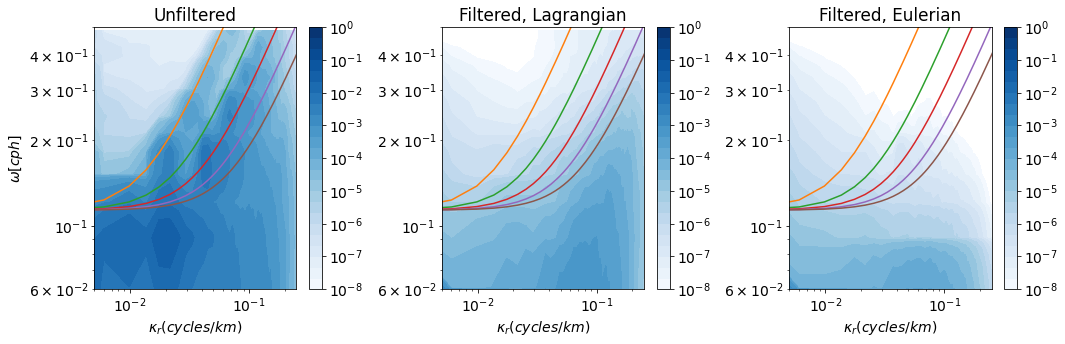

In [218]:
plt.figure(figsize=(15,5))
omega = ps_iso.freq_time*3600
kr    = ps_iso.kr
lev_exp = np.linspace(-8,0,25)
lev = np.power(10, lev_exp)
plt.subplot(131)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilt,lev,norm=LogNorm(), cmap='Blues')
plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Unfiltered')

plt.subplot(132)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso,lev,norm=LogNorm(), cmap='Blues')
plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Lagrangian')

plt.subplot(133)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eul,lev,norm=LogNorm(), cmap='Blues')
plt.colorbar(cs)

for i in range(0,6):
    plt.plot(kr, omegaM[:,i]/np.pi, label=i)
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.06, 0.5])
#plt.ylabel('$\omega [cph] $')
plt.xlabel('$\kappa_r (cycles/km)$')
plt.tight_layout()
plt.title('Filtered, Eulerian')

fig=plt.gcf()
fig.savefig('wavenumber_freq.png')

In [215]:
ps_iso.freq_time[17]*3600*2

<xarray.DataArray 'freq_time' ()>
array(0.06060606)
Coordinates:
    freq_time  float64 8.418e-06

In [ ]:
ds = xr.open_zarr(fnames[0])
ds = ds.isel(niter=slice(1,74))
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)

In [28]:
window_width=30
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)

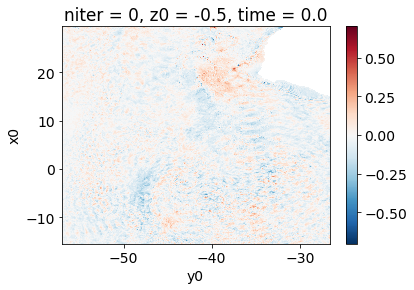

In [34]:
(ds.u-windowed_u).sel(time=0).isel(z0=3).plot()

In [54]:
for fileno in range(0,35):
    print(str(6048+fileno*144))

6048
6192
6336
6480
6624
6768
6912
7056
7200
7344
7488
7632
7776
7920
8064
8208
8352
8496
8640
8784
8928
9072
9216
9360
9504
9648
9792
9936
10080
10224
10368
10512
10656
10800
10944
